In [1]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, features, next_month) = get_features_and_data()

training examples = 2286, testing examples = 255


## Model-Building and Evaluation

In [3]:
def train_model(train_df):
    ct = ColumnTransformer(remainder="passthrough",
                           transformers=[
                               ("ss", StandardScaler(), ["days_since_previous_release", "month_holidays"])])

    pipeline = Pipeline(
        [("ct", ct), ("en", ElasticNet(random_state=1024))])

    model = GridSearchCV(
        pipeline,
        param_grid={"en__alpha" : [0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 1.5, 2],
                    "en__l1_ratio" : [0, 0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
        scoring="neg_mean_absolute_percentage_error", cv=3, refit=True)
    
    model.fit(train_df[features], train_df["prob_of_release"])
    
    return model

In [4]:
model = train_model(train_df)

In [5]:
model.best_params_

{'en__alpha': 1e-05, 'en__l1_ratio': 0}

In [6]:
model.best_score_ * -1

0.38015723500174303

In [7]:
sorted(zip(model.feature_names_in_, model.best_estimator_["en"].coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.16857342581122925),
 ('M_Sep', 0.04569454110807528),
 ('WD_Wednesday', 0.031013070677353614),
 ('WD_Thursday', 0.026908541007782817),
 ('month_holidays', 0.026599696520937455),
 ('M_Apr', 0.017406509597820176),
 ('M_Jul', 0.017154311444671375),
 ('M_Jun', 0.016766528598441795),
 ('M_Oct', 0.012192711194604834),
 ('M_May', 0.007812064273418927),
 ('M_Aug', 0.0035197519026042966),
 ('WD_Tuesday', 0.001705681729652423),
 ('WD_Friday', -0.0029572052633660647),
 ('M_Jan', -0.009806049376897127),
 ('M_Nov', -0.011486970712913406),
 ('M_Dec', -0.01924069666465588),
 ('WD_Saturday', -0.036735521954237293),
 ('WD_Monday', -0.03845218479070006),
 ('M_Mar', -0.04358197152900684),
 ('WD_Sunday', -0.05089296215056289),
 ('M_Feb', -0.08575885560756737),
 ('previous_release_post', -0.21238889335008868)]

In [8]:
test_df["predicted_prob"] = model.predict(test_df[features])
test_df["predicted_prob"] = test_df["predicted_prob"].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [9]:
mape(test_df["prob_of_release"], test_df["predicted_prob"])

0.32052925886488776

In [10]:
wape(test_df["prob_of_release"], test_df["predicted_prob"])

0.25407465050339234

In [11]:
test_df["residuals"] = test_df["predicted_prob"] - test_df["prob_of_release"]
# sns.scatterplot(data=test_df, x="predicted_prob", y="residuals", s=75)

In [12]:
test_df[["index", "prob_of_release", "predicted_prob", "residuals"]].sort_values(by=["residuals"])

,index,prob_of_release,predicted_prob,residuals
2507,2023-12-30,1.000000,0.395685,-0.604315
2373,2023-08-18,1.000000,0.429144,-0.570856
2534,2024-01-26,1.000000,0.461978,-0.538022
2352,2023-07-28,1.000000,0.465859,-0.534141
2432,2023-10-16,1.000000,0.476792,-0.523208
...,...,...,...,...
2343,2023-07-19,0.500000,0.756777,0.256777
2449,2023-11-02,0.250000,0.513242,0.263242
2339,2023-07-15,0.214286,0.483470,0.269184
2407,2023-09-21,0.250000,0.524265,0.274265


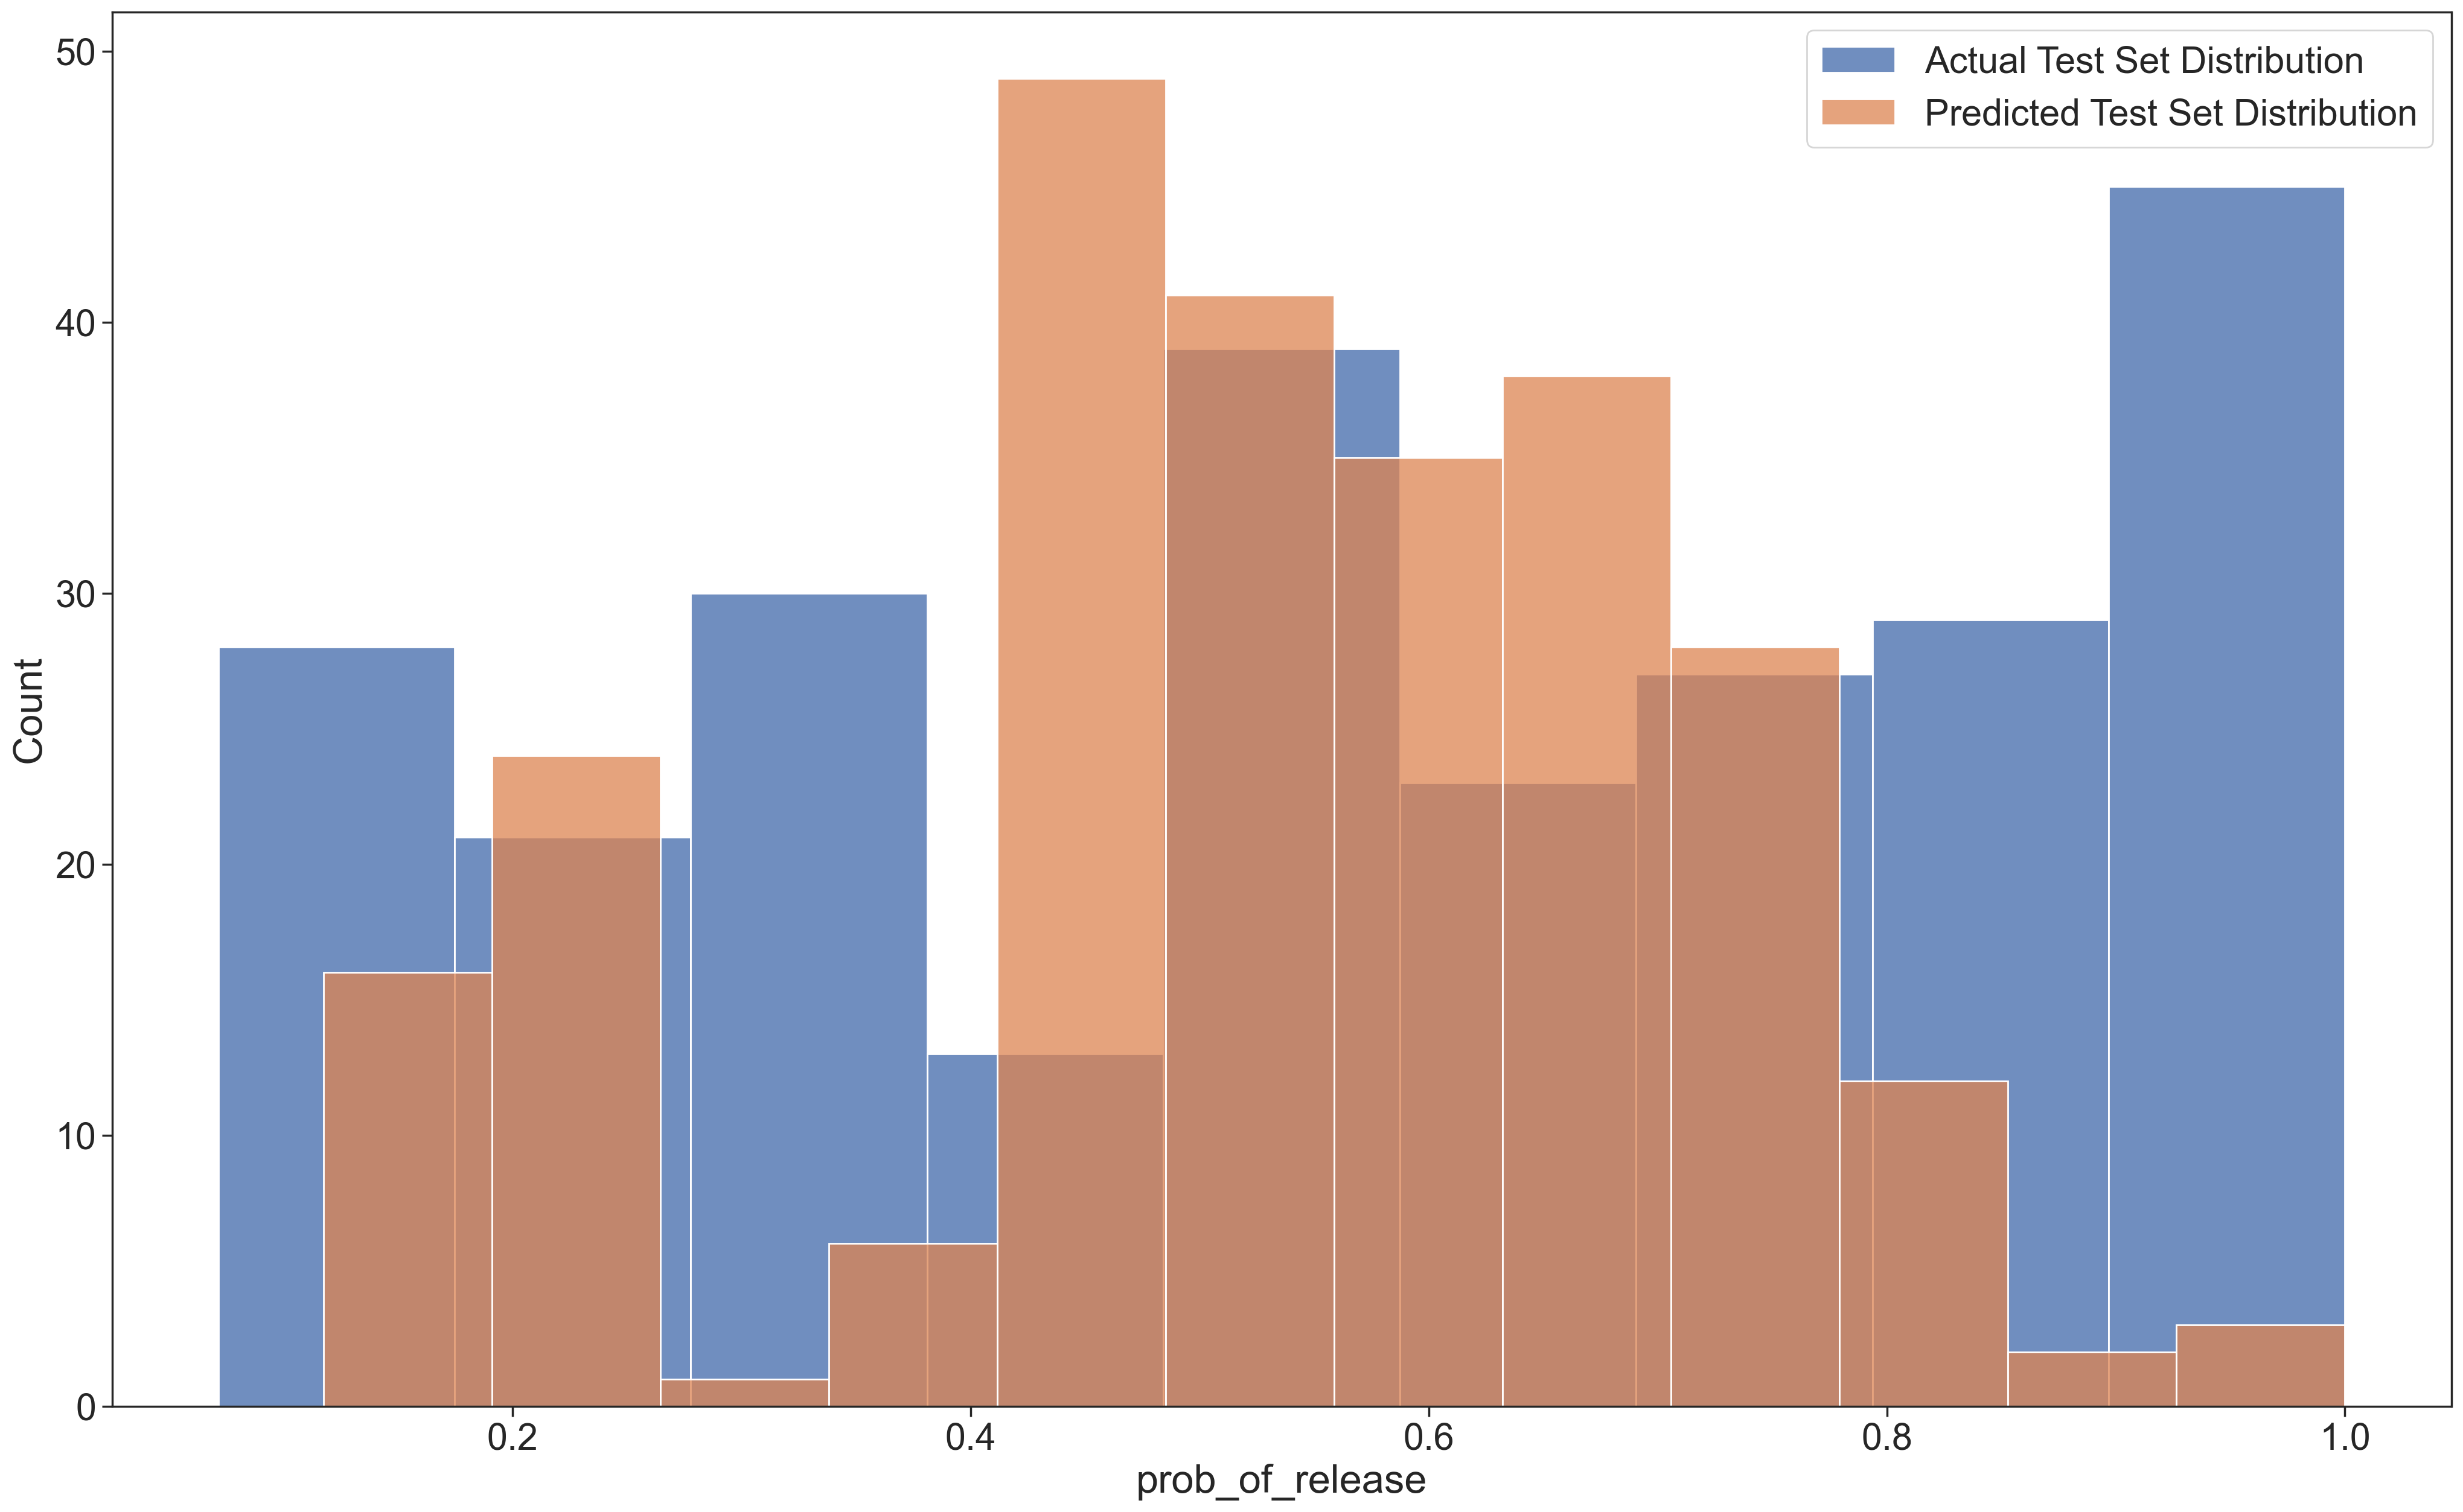

In [13]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["predicted_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Month

In [14]:
model = train_model(df)

In [15]:
# based on https://machinelearningmastery.com/prediction-intervals-for-machine-learning/

preds = model.predict(df[features])
preds[preds < 0] = 0
preds[preds > 1] = 1

sum_errs = np.sum((df["prob_of_release"] - preds) ** 2)
stdev = np.sqrt(1 / (len(df["prob_of_release"]) - 2) * sum_errs)
stdev

0.18603811882787574

In [16]:
next_month["predicted_prob"] = model.predict(next_month[features])
next_month["predicted_prob"] = next_month["predicted_prob"].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [17]:
next_month["predicted_min"] = next_month["predicted_prob"] - (1.96 * stdev)
next_month["predicted_min"] = next_month["predicted_min"].apply(lambda x : 0 if x < 0 else x)
next_month["predicted_max"] = next_month["predicted_prob"] + (1.96 * stdev)
next_month["predicted_max"] = next_month["predicted_max"].apply(lambda x : 1 if x > 1 else x)

In [18]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]]

,index,predicted_min,predicted_prob,predicted_max
7,2024-02-09,0.335103,0.699737,1
8,2024-02-10,0.343432,0.708067,1
9,2024-02-11,0.379829,0.744463,1
10,2024-02-12,0.450317,0.814951,1
11,2024-02-13,0.543073,0.907708,1
12,2024-02-14,0.624723,0.989358,1
13,2024-02-15,0.635365,1.000000,1
14,2024-02-16,0.635365,1.000000,1
15,2024-02-17,0.635365,1.000000,1
16,2024-02-18,0.635365,1.000000,1


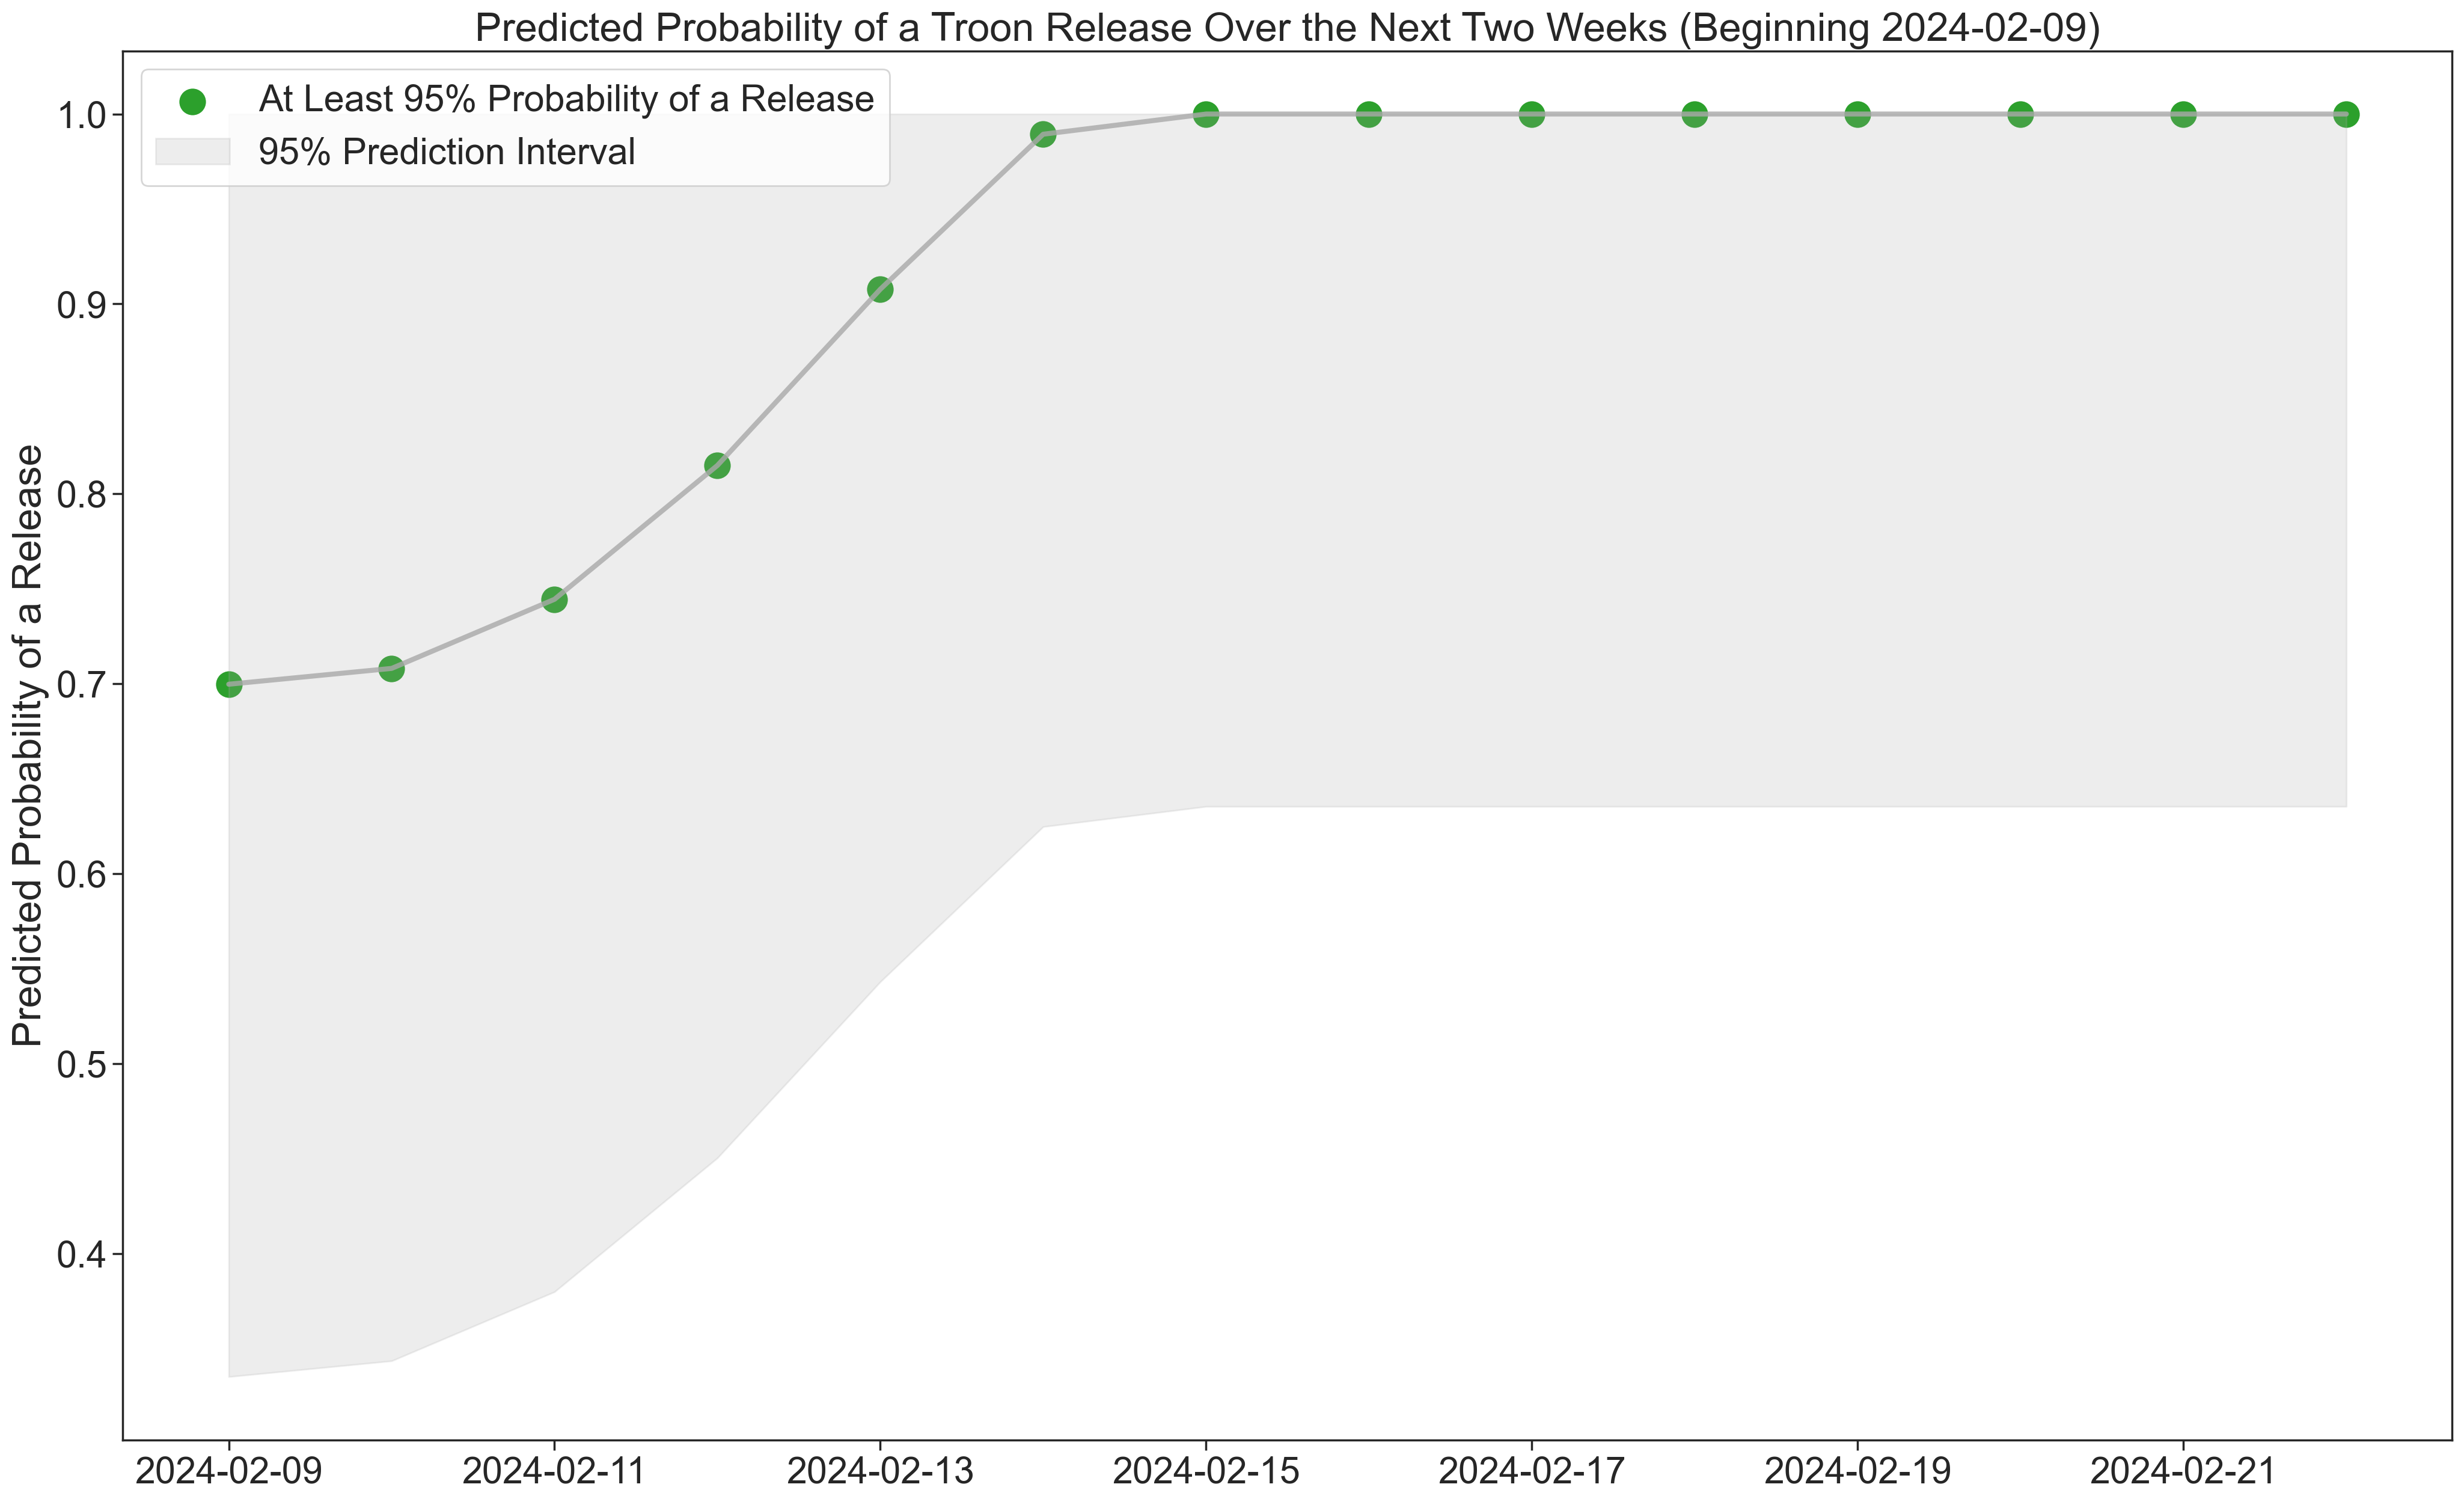

In [19]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 95% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% Prediction Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()